## Mikołaj Murasik - klasyfikacja grzybów na jadalne i trujące

### Opis dostępnych danych

Opracowujemy zbiór danych klasyfikujący grzyby na jadalne i niejadalne.

Najpierw chcemy zbadać, jak ten zbiór wygląda: jego wielkość, liczbę i charakter klas, ilość brakujących danych.

In [208]:
import pandas as pd

dtf = pd.read_csv('dataset_24_mushroom.csv')

Wymiary tabeli:

In [209]:
dtf.shape

(8124, 23)

In [210]:
dtf.head()

,cap-shape,cap-surface,cap-color,bruises%3F,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,'x','s','n','t','p','f','c','n','k','e',...,'w','w','p','w','o','p','k','s','u','p'
1,'x','s','y','t','a','f','c','b','k','e',...,'w','w','p','w','o','p','n','n','g','e'
2,'b','s','w','t','l','f','c','b','n','e',...,'w','w','p','w','o','p','n','n','m','e'
3,'x','y','w','t','p','f','c','n','n','e',...,'w','w','p','w','o','p','k','s','u','p'
4,'x','s','g','f','n','f','w','b','k','t',...,'w','w','p','w','o','e','n','a','g','e'


Czy dane są: ciągłe, dyskretne czy kategoryczne?

In [211]:
print("Nazwa kolumny\ttyp danych")
for c in dtf.columns:
    if (dtf[c].nunique() < 15):
        res = "categorical"
    else:
        res = "numeric"    
    print(c, "\t", res, sep='')

Nazwa kolumny	typ danych
cap-shape	categorical
cap-surface	categorical
cap-color	categorical
bruises%3F	categorical
odor	categorical
gill-attachment	categorical
gill-spacing	categorical
gill-size	categorical
gill-color	categorical
stalk-shape	categorical
stalk-root	categorical
stalk-surface-above-ring	categorical
stalk-surface-below-ring	categorical
stalk-color-above-ring	categorical
stalk-color-below-ring	categorical
veil-type	categorical
veil-color	categorical
ring-number	categorical
ring-type	categorical
spore-print-color	categorical
population	categorical
habitat	categorical
class	categorical


Widzimy więc, że wszystkie dane są podzielone na klasy; nie ma danych numerycznych. W takim razie chcielibyśmy wiedzieć, ile jest możliwych klas każdego typu danych oraz czy nie brakuje żadnych informacji.

In [212]:
print("Nazwa kolumny\tLiczba klas\tLiczba brakujących danych")
for c in dtf.columns:
    print(c, "\t", dtf[c].nunique(), "\t", dtf[c].value_counts().get("?"))

Nazwa kolumny	Liczba klas	Liczba brakujących danych
cap-shape 	 6 	 None
cap-surface 	 4 	 None
cap-color 	 10 	 None
bruises%3F 	 2 	 None
odor 	 9 	 None
gill-attachment 	 2 	 None
gill-spacing 	 2 	 None
gill-size 	 2 	 None
gill-color 	 12 	 None
stalk-shape 	 2 	 None
stalk-root 	 5 	 2480
stalk-surface-above-ring 	 4 	 None
stalk-surface-below-ring 	 4 	 None
stalk-color-above-ring 	 9 	 None
stalk-color-below-ring 	 9 	 None
veil-type 	 1 	 None
veil-color 	 4 	 None
ring-number 	 3 	 None
ring-type 	 5 	 None
spore-print-color 	 9 	 None
population 	 6 	 None
habitat 	 7 	 None
class 	 2 	 None


Jak widać, brak danych występuje tylko w jednej kolumnie: <samp>stalk-root</samp>. Brakuje tam danych w 2480 wierszach, czyli w blisko 30%.

<b>Podsumowując</b>, dane składają się zatem z:
<ul>
    <li>8124 wierszy, z których każdy opisuje oddzielną obserwację</li>
    <li>22 klas (+1 opisująca wynik), każda o wartościach kategorycznych</li>
    <li>poza klasą <samp>stalk-root</samp> wszędzie dostępne są pełne dane
</ul>

Chcielibyśmy jeszcze sprawdzić, czy danych nie mamy nadreprezentacji któregoś rodzaju grzybów:

<function matplotlib.pyplot.show(close=None, block=None)>

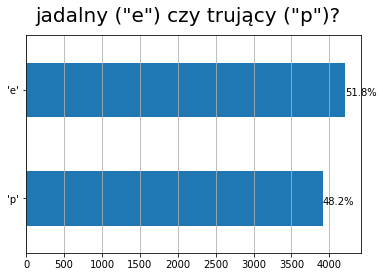

In [213]:
import matplotlib.pyplot as plt

ax = dtf["class"].value_counts().sort_values().plot(kind="barh")
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width() + .3, i.get_y() + .2, str(round((i.get_width() / total) * 100, 2)) + '%', fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle('jadalny ("e") czy trujący ("p")?', fontsize=20)
plt.show

Widać, że dane są dobrze podzielone, więc powinniśmy być w stanie dobrze nauczyć klasyfikator rozpoznawania obu rodzajów grzybów.

### Modyfikacja danych

Ponieważ dane są dobrze podzielone oraz wszystkie są kategoryczne, to pozostaje już tylko wybrać klasyfikator.

Najpierw dane w postaci liter zastępujemy wektorami binarnymi. Klasa <em>class</em> (oznaczająca, czy dany grzyb jest jadalny) zostanie zastąpiona dwoma komplementarnymi klasami, więc jedną z nich usuwamy.

In [214]:
dtf2 = pd.DataFrame()
for c in dtf.columns:
    dummy = pd.get_dummies(dtf[c], prefix = c, drop_first = False)
    dtf2 = pd.concat([dtf2, dummy], axis = 1)

dtf2 = dtf2.drop("class_'p'", axis = 1)
dtf2 = dtf2.rename({"class_'e'" : "edible"}, axis = 1)
dtf2

,cap-shape_'b',cap-shape_'c',cap-shape_'f',cap-shape_'k',cap-shape_'s',cap-shape_'x',cap-surface_'f',cap-surface_'g',cap-surface_'s',cap-surface_'y',...,population_'v',population_'y',habitat_'d',habitat_'g',habitat_'l',habitat_'m',habitat_'p',habitat_'u',habitat_'w',edible
0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
8120,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,0,1
8121,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
8122,0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


Dzielimy dane na treningowe i testowe:

In [215]:
from sklearn import model_selection, feature_selection, ensemble, metrics

train_test_ratio = 0.33

dtf_train, dtf_test = model_selection.train_test_split(dtf2, test_size = train_test_ratio)
print("Train shape:", dtf_train.shape)
print("Test shape:", dtf_test.shape)

Train shape: (5443, 118)
Test shape: (2681, 118)


### Wybór cech

Wybieramy najlepsze cechy przy użyciu losowych drzew:

In [216]:
import numpy as np

importance_treshold = 0.01

xs = dtf_train.drop("edible", axis = 1).values
y = dtf_train["edible"].values
features = dtf_train.drop("edible", axis = 1).columns.tolist()

model = ensemble.RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 0)
model.fit(xs, y)
importances = model.feature_importances_

dtf_importances = pd.DataFrame({"ważność":importances, "cecha":features}).sort_values("ważność", ascending = False)
best_features = dtf_importances.query("ważność > " + str(importance_treshold))["cecha"].tolist()

best_features

["odor_'n'",
 "gill-size_'b'",
 "odor_'f'",
 "gill-color_'b'",
 "spore-print-color_'h'",
 "gill-size_'n'",
 "stalk-surface-below-ring_'k'",
 "stalk-surface-above-ring_'k'",
 "ring-type_'l'",
 "ring-type_'p'",
 "bruises%3F_'f'",
 "stalk-surface-above-ring_'s'",
 "population_'v'",
 "stalk-root_'b'",
 "stalk-shape_'t'",
 "odor_'p'",
 "gill-spacing_'w'",
 "bruises%3F_'t'",
 "spore-print-color_'w'",
 "stalk-root_'c'",
 "gill-spacing_'c'",
 "stalk-shape_'e'",
 'stalk-root_?',
 "stalk-surface-below-ring_'s'",
 "spore-print-color_'r'"]

Tworzymy nowe dataframe'y na podstawie wybranych cech:

In [217]:
xs_train = dtf_train[best_features].values
y_train = dtf_train["edible"].values

xs_test = dtf_test[best_features].values
y_test = dtf_test["edible"].values

### Klasyfikacja

Do klasyfikacji będziemy używać metody <em>gradient boosting</em>. Wybieramy optymalne parametry:

In [218]:
model = ensemble.GradientBoostingClassifier()

params = {'learning_rate' : [0.008, 0.005, 0.002, 0.001], 'n_estimators' : [5, 10, 15, 25], 'max_depth' : [2, 3, 4, 5], 'min_samples_split' : [2, 5, 10, 20, 30], 'min_samples_leaf' : [1, 2, 3, 5], 'max_features' : [3, 4, 5, 6], 'subsample' : [0.85, 0.9, 0.95, 1.0]}
best_model = model_selection.RandomizedSearchCV(model, param_distributions = params, n_iter = 100, scoring = "accuracy").fit(xs_train, y_train)

model = best_model.best_estimator_
model

GradientBoostingClassifier(learning_rate=0.008, max_depth=5, max_features=6,
                           min_samples_leaf=2, min_samples_split=30,
                           n_estimators=25, subsample=0.95)

A następnie uczymy i testujemy klasyfikator:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1297
           1       1.00      1.00      1.00      1384

    accuracy                           1.00      2681
   macro avg       1.00      1.00      1.00      2681
weighted avg       1.00      1.00      1.00      2681



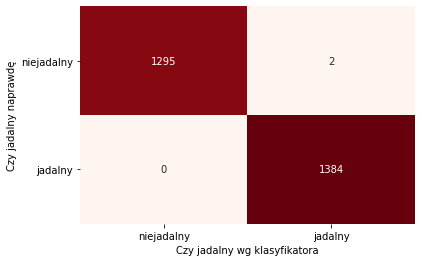

In [219]:
model.fit(xs_train, y_train)

predicted = model.predict(xs_test)
print(metrics.classification_report(y_test, predicted, target_names = [str(i) for i in np.unique(y_test)]))

import seaborn as sns

classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = plt.cm.Reds, cbar = False)
ax.set(xlabel = "Czy jadalny wg klasyfikatora", ylabel = "Czy jadalny naprawdę")
ax.set_xticklabels(labels = ["niejadalny", "jadalny"], rotation = 0)
ax.set_yticklabels(labels = ["niejadalny", "jadalny"], rotation = 0)
plt.show()

Z powyższych danych wynika, że nasz klasyfikator ma następujące własności:
<ul>
    <li><em>Accuracy</em>: 1.0</li>
    <li><em>Recall</em>: 1.0</li>
    <li><em>Precision</em>: (prawie) 1.0</li>
</ul>

Okazuje się zatem, że klasyfikator działa dobrze, choć niepokojące jest, że w 2 przypadkach niepoprawnie sklasyfikował grzyba trującego jako jadalnego, podczas gdy odwrotnego błędu nie popełnił ani razu.